# **TUGAS PRAKTIKUM**
1. Tugas K-Means
Buatlah sebuah model K-Means dengan ketentuan,
- Gunakan data 'Mall_Customers.csv'
- Tentukan fitur apa yang tepat untuk melakukan clustering (minimal 2)
- Buatlah model K-Means dengan mempertimbangkan jumlah k yang terbaik.

2. Tugas DBSCAN
- Buat dataset make_moons (1000 sampel, noise=0.05), lalu normalisasi.
- Jalankan DBSCAN dengan eps=0.2, min_samples=5, hitung jumlah klaster & noise.
- Evaluasi dengan metrik: Homogeneity, Completeness, V-measure, ARI, AMI, Silhouette.
- Visualisasikan hasil DBSCAN (core sample = titik besar, non-core = titik kecil, noise = hitam).
- Lakukan eksperimen:
  - eps = 0.05, 0.1, 0.3, 0.5
  - min_samples = 3, 10, 20
  - Catat perubahan klaster, noise, dan kualitas evaluasi.

[Income–Spending] fitur = ['Annual Income (k$)', 'Spending Score (1-100)']
{'silhouette': 5, 'CH': 9, 'DB': 5, 'best_k': 5}
[Age–Spending] fitur = ['Age', 'Spending Score (1-100)']
{'silhouette': 2, 'CH': 10, 'DB': 10, 'best_k': 10}


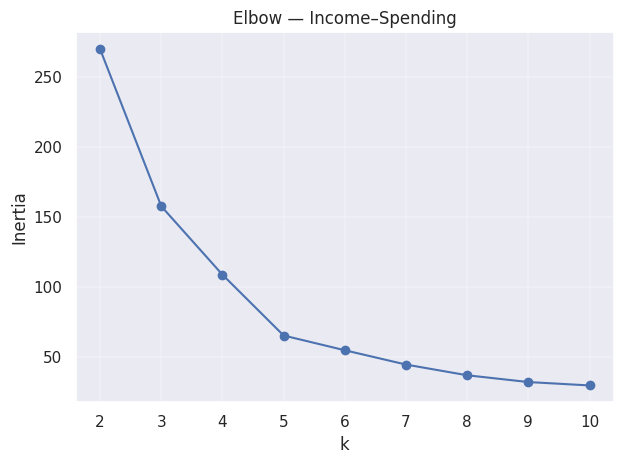

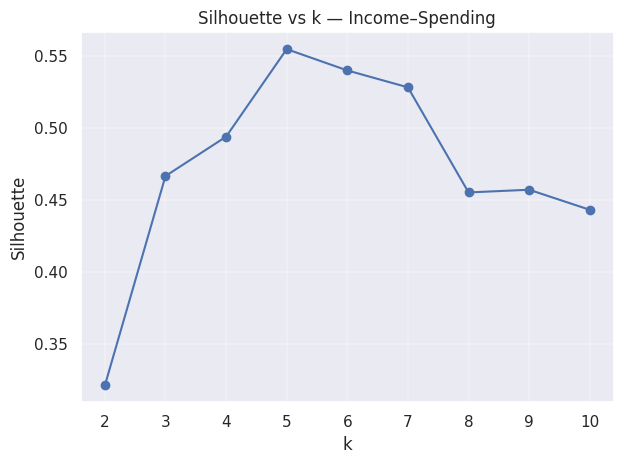

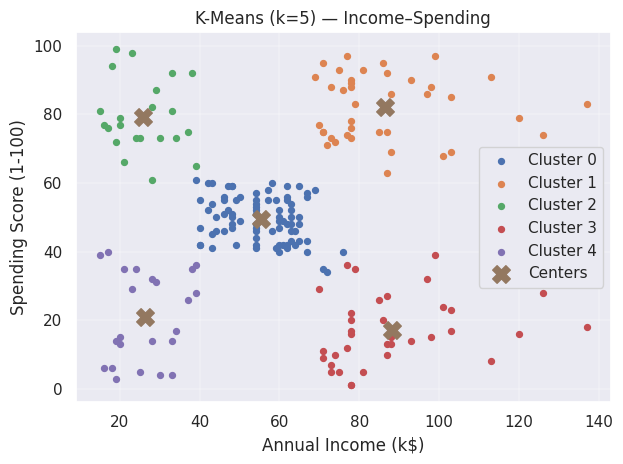

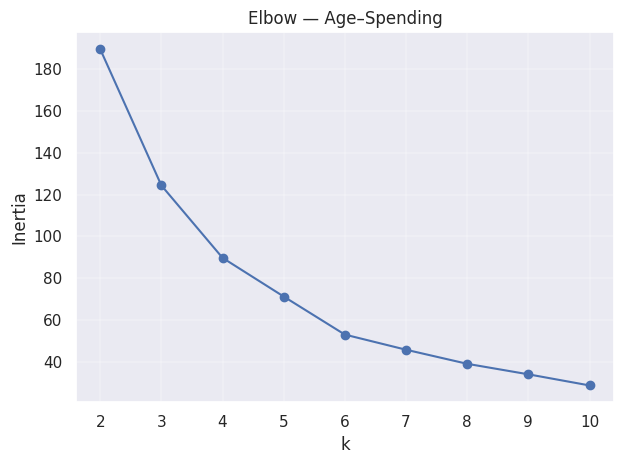

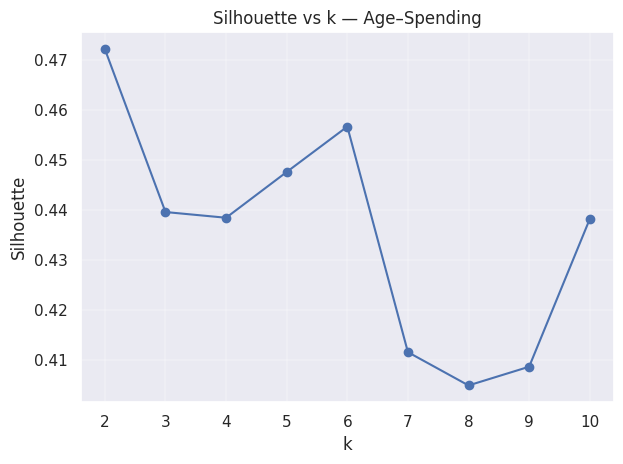

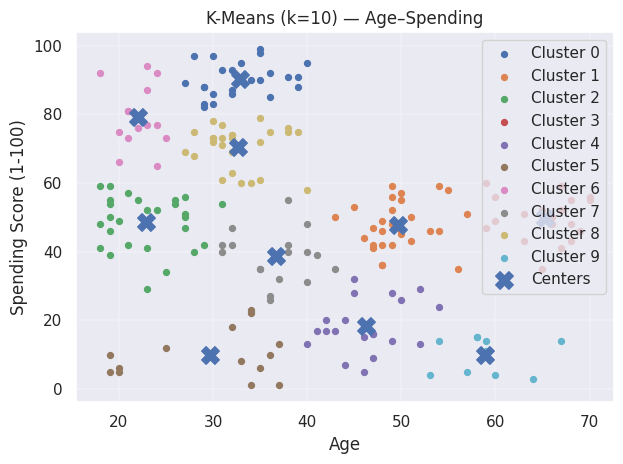

In [ ]:
# Soal 1
# Mall Customers dengan melakukan perbandingan 2 set fitur (Income–Spending vs Age–Spending) import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from collections import Counter
import re

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine_Learning_25/Mall_Customers.csv')

# 2) Helper: cari kolom by regex (case-insensitive)
def find_col(df, patterns, default=None):
    for pat in patterns:
        rx = re.compile(pat, re.I)
        for c in df.columns:
            if rx.search(c):
                return c
    return default

# 3) Deteksi kolom utama
income = find_col(df, [r"annual\s*income", r"\bincome\b"], "Annual Income (k$)")
spend  = find_col(df, [r"spending\s*score", r"\bspending\b.*\bscore\b"], "Spending Score (1-100)")
age    = find_col(df, [r"\bage\b"], "Age")

# Fallback jika nama kolom beda
nums = df.select_dtypes(include=[np.number]).columns.tolist()
if income not in df.columns and nums: income = nums[0]
if spend not in df.columns and len(nums) > 1: spend = nums[1]
if age not in df.columns:
    alt = [c for c in nums if c not in {income, spend}]
    age = alt[0] if alt else spend  # fallback aman

# 4) Fungsi evaluasi k untuk 1 set fitur
def evaluate_feature_set(X_orig, k_range=range(2,11), seed=42):
    scaler = StandardScaler()
    X = scaler.fit_transform(X_orig.values)

    inertias, sils, chs, dbs = [], [], [], []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=seed, n_init=10).fit(X)
        y = km.labels_
        inertias.append(km.inertia_)
        sils.append(silhouette_score(X, y))
        chs.append(calinski_harabasz_score(X, y))
        dbs.append(davies_bouldin_score(X, y))

    k_list = list(k_range)
    k_sil = k_list[int(np.argmax(sils))]
    k_ch  = k_list[int(np.argmax(chs))]
    k_db  = k_list[int(np.argmin(dbs))]

    vote = Counter([k_sil, k_ch, k_db])
    best_k = vote.most_common(1)[0][0]

    # Fit final dan kembali ke satuan asli
    km = KMeans(n_clusters=best_k, random_state=seed, n_init=10).fit(X)
    centers_orig = scaler.inverse_transform(km.cluster_centers_)
    labels = km.labels_

    metrics_df = pd.DataFrame({
        "k": k_list,
        "inertia": inertias,
        "silhouette": sils,
        "calinski_harabasz": chs,
        "davies_bouldin": dbs
    })
    return {
        "metrics": metrics_df,
        "k_sil": k_sil, "k_ch": k_ch, "k_db": k_db, "best_k": best_k,
        "labels": labels, "centers_orig": centers_orig
    }

# 5) dua set fitur
fs1_name, fs1_cols = "Income–Spending", [income, spend]
fs2_name, fs2_cols = "Age–Spending",    [age, spend]

X1 = df[fs1_cols].dropna().copy()
X2 = df[fs2_cols].dropna().copy()

res1 = evaluate_feature_set(X1)
res2 = evaluate_feature_set(X2)

print(f"[{fs1_name}] fitur = {fs1_cols}")
print({"silhouette": int(res1["k_sil"]), "CH": int(res1["k_ch"]), "DB": int(res1["k_db"]), "best_k": int(res1["best_k"])})
print(f"[{fs2_name}] fitur = {fs2_cols}")
print({"silhouette": int(res2["k_sil"]), "CH": int(res2["k_ch"]), "DB": int(res2["k_db"]), "best_k": int(res2["best_k"])})

# 6) Plot untuk setiap set fitur (1 figur per metrik, sesuai aturan)
def plot_elbow(metrics, title_suffix=""):
    plt.figure()
    plt.plot(metrics["k"], metrics["inertia"], marker="o")
    plt.xlabel("k"); plt.ylabel("Inertia"); plt.title(f"Elbow{title_suffix}")
    plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()

def plot_sil(metrics, title_suffix=""):
    plt.figure()
    plt.plot(metrics["k"], metrics["silhouette"], marker="o")
    plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title(f"Silhouette vs k{title_suffix}")
    plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()

def plot_scatter(X_orig, labels, centers_orig, title_suffix=""):
    plt.figure()
    k = len(np.unique(labels))
    for c in range(k):
        m = (labels == c)
        plt.scatter(X_orig.iloc[m,0], X_orig.iloc[m,1], s=18, label=f"Cluster {c}")
    plt.scatter(centers_orig[:,0], centers_orig[:,1], s=160, marker="X", label="Centers")
    plt.xlabel(X_orig.columns[0]); plt.ylabel(X_orig.columns[1])
    plt.title(f"K-Means (k={k}){title_suffix}")
    plt.legend(); plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()

# Income–Spending
plot_elbow(res1["metrics"], f" — {fs1_name}")
plot_sil(res1["metrics"],   f" — {fs1_name}")
plot_scatter(X1, res1["labels"], res1["centers_orig"], f" — {fs1_name}")

# Age–Spending
plot_elbow(res2["metrics"], f" — {fs2_name}")
plot_sil(res2["metrics"],   f" — {fs2_name}")
plot_scatter(X2, res2["labels"], res2["centers_orig"], f" — {fs2_name}")

=== Base run (eps=0.2, min_samples=5) ===
  n_clusters: 2
     n_noise: 0
 homogeneity: 1.0
completeness: 1.0
   v_measure: 1.0
         ARI: 1.0
         AMI: 1.0
  silhouette: 0.3911598537138403


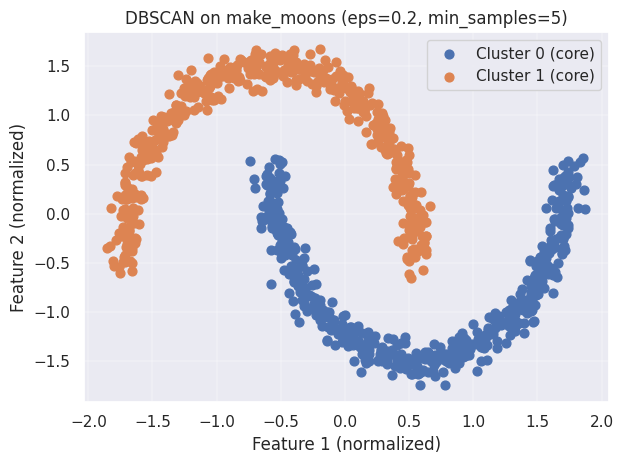


=== Ringkasan eksperimen (diurutkan eps, min_samples) ===
 eps  min_samples  n_clusters  n_noise  homogeneity  completeness  v_measure      ARI      AMI  silhouette
0.05            3          69      186     0.815554      0.152548   0.257021 0.030044 0.243805    0.112929
0.05           10           3      970     0.030669      0.126764   0.049389 0.002283 0.045864   -0.294190
0.05           20           0     1000     0.000000      1.000000   0.000000 0.000000 0.000000         NaN
0.10            3           2       14     0.986207      0.902896   0.942714 0.972179 0.942634    0.251690
0.10           10           7       57     0.943317      0.409546   0.571132 0.523399 0.569801    0.162306
0.10           20           6      850     0.153928      0.155466   0.154693 0.016754 0.150916   -0.360195
0.30            3           2        0     1.000000      1.000000   1.000000 1.000000 1.000000    0.391160
0.30           10           2        0     1.000000      1.000000   1.000000 1.000000

In [ ]:
# Soal 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
)

# 1) dataset make_moons (1000 sampel, noise=0.05)
X, y_true = make_moons(n_samples=1000, noise=0.05, random_state=42)
scaler = StandardScaler()
Xn = scaler.fit_transform(X)

def run_dbscan(Xn, y_true, eps=0.2, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(Xn)
    labels = db.labels_

    unique_labels = set(labels)
    n_clusters = len([l for l in unique_labels if l != -1])
    n_noise = int(np.sum(labels == -1))

    # Metrik berbasis ground-truth (y_true) dan assignment DBSCAN (labels)
    homo = homogeneity_score(y_true, labels)
    comp = completeness_score(y_true, labels)
    vmes = v_measure_score(y_true, labels)
    ari  = adjusted_rand_score(y_true, labels)
    ami  = adjusted_mutual_info_score(y_true, labels)

    # Silhouette hanya valid bila ada >=2 klaster dan tidak semua noise
    try:
        sil = silhouette_score(Xn, labels) if n_clusters >= 2 and n_noise < len(labels) else np.nan
    except Exception:
        sil = np.nan

    metrics = {
        "n_clusters": n_clusters,
        "n_noise": n_noise,
        "homogeneity": homo,
        "completeness": comp,
        "v_measure": vmes,
        "ARI": ari,
        "AMI": ami,
        "silhouette": sil
    }
    return db, labels, metrics

# 2) Run dasar: DBSCAN eps=0.2, min_samples=5
db_base, labels_base, base_metrics = run_dbscan(Xn, y_true, eps=0.2, min_samples=5)
print("=== Base run (eps=0.2, min_samples=5) ===")
for k, v in base_metrics.items():
    print(f"{k:>12}: {v}")

#    core sample = marker besar, non-core (border) = marker kecil, noise = hitam
core_mask = np.zeros_like(labels_base, dtype=bool)
core_indices = getattr(db_base, "core_sample_indices_", None)
if core_indices is not None:
    core_mask[core_indices] = True

unique_labels_base = sorted(set(labels_base))

plt.figure()
for lbl in unique_labels_base:
    class_member_mask = (labels_base == lbl)

    if lbl == -1:
        # noise ke hitam
        xy = Xn[class_member_mask]
        if len(xy):
            plt.scatter(xy[:, 0], xy[:, 1], s=10, c="k", label="Noise")
    else:
        # core points (besar)
        xy_core = Xn[class_member_mask & core_mask]
        if len(xy_core):
            plt.scatter(xy_core[:, 0], xy_core[:, 1], s=40, label=f"Cluster {lbl} (core)")
        # non-core / border (kecil)
        xy_border = Xn[class_member_mask & ~core_mask]
        if len(xy_border):
            plt.scatter(xy_border[:, 0], xy_border[:, 1], s=10, label=f"Cluster {lbl} (border)")

plt.title("DBSCAN on make_moons (eps=0.2, min_samples=5)")
plt.xlabel("Feature 1 (normalized)")
plt.ylabel("Feature 2 (normalized)")
plt.legend(loc="best", markerscale=1.0)
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

# 3) Eksperimen kombinasi parameter:
#    eps = 0.05, 0.1, 0.3, 0.5
#    min_samples = 3, 10, 20
eps_list = [0.05, 0.1, 0.3, 0.5]
min_samples_list = [3, 10, 20]

rows = []
for eps in eps_list:
    for ms in min_samples_list:
        _, _, m = run_dbscan(Xn, y_true, eps=eps, min_samples=ms)
        row = {"eps": eps, "min_samples": ms}
        row.update(m)
        rows.append(row)

exp_df = pd.DataFrame(rows).sort_values(["eps", "min_samples"]).reset_index(drop=True)
print("\n=== Ringkasan eksperimen (diurutkan eps, min_samples) ===")
print(exp_df.to_string(index=False))